# NFL Fantasy Football - Captsone Project

In [304]:
# Importing all the necessary modules

import pandas as pd
import numpy as np
import requests
import time

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV,\
RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from operator import itemgetter
from math import sqrt

import seaborn as sns
from matplotlib import pyplot as plt

# Part 1 - Webscraping

1. Here we use Request to get access to the desired website
    - Side note, this took a little bit of time because I wasn't aware of headers and kept getting a 403 FORBIDDEN error. This video https://www.youtube.com/watch?v=6RfyXcf_vQo , helped me get through this
2. Then we use urlopen to get the raw html code
3. Finally we use BeautifulSoup to parse the html code and have it in a decipherable format
4. Inspect the variable soup to make sure it's working!


In [163]:
url2 = 'https://www.footballdb.com/teams/index.html'
req2 = Request(url2, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}) # Make a get request to retrieve the page
webpage2 = urlopen(req2).read()
soup2 = BeautifulSoup(webpage2, 'html.parser') # Pass the page contents to beautiful soup for parsing
soup2

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="initial-scale=1.0, width=device-width" name="viewport"/>
<title>Teams | The Football Database</title>
<meta content="View stats and statistics, rosters, results, draft results and transactions for current and defunct NFL teams" name="description"/>
<meta content="index,follow" name="robots"/>
<meta content="FootballDB.com" property="og:site_name"/>
<meta content="Teams | The Football Database" property="og:title">
<meta content="website" property="og:type"/>
<meta content="View stats and statistics, rosters, results, draft results and transactions for current and defunct NFL teams" property="og:description"/>
<meta content="https://www.footballdb.com/images/footballdb_200x200.png" property="og:image"/>
<meta content="https://www.footballdb.com/teams/index.html" property="og:url"/>
<meta content="summary" name="twitter:card"/>
<meta content="@TheFootball

# Part 1.1 - Team url's

We're going to use the soup from the previous part and extract each NFL team's url

1. The urls are located in a table, so we have to find the table body 'tbody' and then find all the table rows 'tr' where they're located
2. Unfortunately in all the '< a >' tags the href was only the latter part of the url
    - ie. '/teams/nfl/buffalo-bills/stats'
3. Once we have the latter part of the url, we add it to the base part of the url that every team website needs in order for us to later scrape information on each team.
    - ie. 'https://www.footballdb.com' + '/teams/nfl/buffalo-bills/stats'
4. Then we append it to a list that contains each teams url

In [10]:
"""
Getting all the teams stats pages, and appending them to a list for the next step.

Next step will involve going to each team's respective stats page and scraping each player ulr in passing, rushing, 
and receiving categories.

"""

teams = soup2.find('tbody').find_all('tr')

url_part_one = 'https://www.footballdb.com'

team_urls = []
for team in teams:
    if len(team.find_all('a')) > 1:
        a_tags = team.find_all('a')[2]['href']
        team_urls.append(url_part_one+a_tags)
        
team_urls

['https://www.footballdb.com/teams/nfl/buffalo-bills/stats',
 'https://www.footballdb.com/teams/nfl/miami-dolphins/stats',
 'https://www.footballdb.com/teams/nfl/new-england-patriots/stats',
 'https://www.footballdb.com/teams/nfl/new-york-jets/stats',
 'https://www.footballdb.com/teams/nfl/baltimore-ravens/stats',
 'https://www.footballdb.com/teams/nfl/cincinnati-bengals/stats',
 'https://www.footballdb.com/teams/nfl/cleveland-browns/stats',
 'https://www.footballdb.com/teams/nfl/pittsburgh-steelers/stats',
 'https://www.footballdb.com/teams/nfl/houston-texans/stats',
 'https://www.footballdb.com/teams/nfl/indianapolis-colts/stats',
 'https://www.footballdb.com/teams/nfl/jacksonville-jaguars/stats',
 'https://www.footballdb.com/teams/nfl/tennessee-titans/stats',
 'https://www.footballdb.com/teams/nfl/denver-broncos/stats',
 'https://www.footballdb.com/teams/nfl/kansas-city-chiefs/stats',
 'https://www.footballdb.com/teams/nfl/las-vegas-raiders/stats',
 'https://www.footballdb.com/teams

# Part 1.2 - Player url's

We're using the list of team urls to scrape all of their players that have played offense url's

1. In order to retrive each players url we have to do what we did in part 1 to pull and parse each team's html
2. After we have the team's parsed html, we're going to find all of their tables that contain player stats
    - This happens to be the first three tables! Passing, Rushing, Receiving.
3. For each table we have to find all the 'span' tags that contained the 'hidden-xs' class which had each players url
4. Within the variable sub_table we have all the 'hidden-xs', so for example in the Passing table for each 'hidden-xs' class we're going to do the same as part 1.1 and scrape the 'href' of each one
5. We have the same problem as part 1.1 where the href is not complete, so before appending it to the list we have to add the base url and a specific ending so that we can just have their stats for the most recent year
    - 'https://www.footballdb.com' + '/players/josh-allen-allenjo06' + '/gamelogs/2022'
6. Then right before the function ends we have it pause for five seconds, so that the website doens't think anything fishy is going on and our IP does not get banned

In [11]:
complete_players_url_list = []

In [12]:
def team_urls_to_player_list(list_of_team_urls):
    url_part_one = 'https://www.footballdb.com'
    url_part_two = '/gamelogs/2022'
    
    for team in list_of_team_urls:
        
        url = team
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}) # Make a get request to retrieve the page
        webpage = urlopen(req).read()
        soup = BeautifulSoup(webpage, 'html.parser') # Pass the page contents to beautiful soup for parsing
        
        tables = soup.find_all('table')
        
        for i in range(3):
            sub_table = tables[i].find_all('span', class_='hidden-xs')
            for i in range(len(sub_table)):
                player_url = sub_table[i].find('a')['href']
                player_url = url_part_one+player_url+url_part_two
                if player_url not in complete_players_url_list:
                    complete_players_url_list.append(player_url)
        print('Team retrieved')
        complete_players_url_list
        time.sleep(5)
    print('All players urls retrieved!')

In [13]:
team_urls_to_player_list(team_urls)

Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
Team retrieved
All players urls retrieved!


## Checking that all the players url's are there!

In [14]:
complete_players_url_list

['https://www.footballdb.com/players/josh-allen-allenjo06/gamelogs/2022',
 'https://www.footballdb.com/players/case-keenum-keenuca01/gamelogs/2022',
 'https://www.footballdb.com/players/devin-singletary-singlde01/gamelogs/2022',
 'https://www.footballdb.com/players/james-cook-cookja05/gamelogs/2022',
 'https://www.footballdb.com/players/zack-moss-mossza01/gamelogs/2022',
 'https://www.footballdb.com/players/isaiah-mckenzie-mckenis01/gamelogs/2022',
 'https://www.footballdb.com/players/duke-johnson-johnsdu02/gamelogs/2022',
 'https://www.footballdb.com/players/stefon-diggs-diggsst01/gamelogs/2022',
 'https://www.footballdb.com/players/nyheim-hines-hinesny01/gamelogs/2022',
 'https://www.footballdb.com/players/gabriel-davis-davisga05/gamelogs/2022',
 'https://www.footballdb.com/players/dawson-knox-knoxda02/gamelogs/2022',
 'https://www.footballdb.com/players/khalil-shakir-shakikh01/gamelogs/2022',
 'https://www.footballdb.com/players/reggie-gilliam-gillire01/gamelogs/2022',
 'https://www

### Below is the process of iterating to see how to retrieve certain parts of the website

In [15]:
url = 'https://www.footballdb.com/teams/nfl/buffalo-bills/stats'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}) # Make a get request to retrieve the page
webpage = urlopen(req).read()
soup = BeautifulSoup(webpage, 'html.parser') # Pass the page contents to beautiful soup for parsing
soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="initial-scale=1.0, width=device-width" name="viewport"/>
<title>Buffalo Bills Statistics | The Football Database</title>
<meta content="Buffalo Bills stats and statistics for the 2022 NFL season, including rushing, passing, receiving, kickoff returns, punt returns, punting, kicking and defense" name="description"/>
<meta content="index,follow" name="robots"/>
<meta content="FootballDB.com" property="og:site_name"/>
<meta content="Buffalo Bills Statistics | The Football Database" property="og:title">
<meta content="website" property="og:type"/>
<meta content="Buffalo Bills stats and statistics for the 2022 NFL season, including rushing, passing, receiving, kickoff returns, punt returns, punting, kicking and defense" property="og:description"/>
<meta content="https://www.footballdb.com/images/footballdb_200x200.png" property="og:image"/>
<meta content="ht

In [17]:
tables[0].find('span',{'class':'hidden-xs'}).find('a')['href']

'/players/josh-allen-allenjo06'

In [18]:
tables[0].find_all('span')

[<span class="hidden-xs"><a href="/players/josh-allen-allenjo06" title="Josh Allen Stats">Josh Allen</a></span>,
 <span class="visible-xs"><a href="/players/josh-allen-allenjo06" title="Josh Allen Stats">J. Allen</a></span>,
 <span class="hidden-xs"><a href="/players/case-keenum-keenuca01" title="Case Keenum Stats">Case Keenum</a></span>,
 <span class="visible-xs"><a href="/players/case-keenum-keenuca01" title="Case Keenum Stats">C. Keenum</a></span>]

In [12]:
players_list = []
url_part_one = 'https://www.footballdb.com'
url_part_two = '/gamelogs/2022'

for i in range(3):
    sub_table = tables[i].find_all('span', class_='hidden-xs')
    for i in range(len(sub_table)):
        player_url = sub_table[i].find('a')['href']
        player_url = url_part_one+player_url+url_part_two
        if player_url not in players_list:
            players_list.append(player_url)
players_list

['https://www.footballdb.com/players/josh-allen-allenjo06/gamelogs/2022',
 'https://www.footballdb.com/players/case-keenum-keenuca01/gamelogs/2022',
 'https://www.footballdb.com/players/devin-singletary-singlde01/gamelogs/2022',
 'https://www.footballdb.com/players/james-cook-cookja05/gamelogs/2022',
 'https://www.footballdb.com/players/zack-moss-mossza01/gamelogs/2022',
 'https://www.footballdb.com/players/isaiah-mckenzie-mckenis01/gamelogs/2022',
 'https://www.footballdb.com/players/duke-johnson-johnsdu02/gamelogs/2022',
 'https://www.footballdb.com/players/stefon-diggs-diggsst01/gamelogs/2022',
 'https://www.footballdb.com/players/nyheim-hines-hinesny01/gamelogs/2022',
 'https://www.footballdb.com/players/gabriel-davis-davisga05/gamelogs/2022',
 'https://www.footballdb.com/players/dawson-knox-knoxda02/gamelogs/2022',
 'https://www.footballdb.com/players/khalil-shakir-shakikh01/gamelogs/2022',
 'https://www.footballdb.com/players/reggie-gilliam-gillire01/gamelogs/2022',
 'https://www

### Iterating on player's url to see how to extract certain information such as position
- Not every player website had the same format, so I had to figure out a method that would work no matter the formatting
- The solution was to only extract the text if the 'b' tag had the exact word 'Position'

In [178]:
url1 = 'https://www.footballdb.com/players/laquon-treadwell-treadla01/gamelogs/2022'
req1 = Request(url1, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}) # Make a get request to retrieve the page
webpage1 = urlopen(req1).read()
soup1 = BeautifulSoup(webpage1, 'html.parser') # Pass the page contents to beautiful soup for parsing
soup1

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="initial-scale=1.0, width=device-width" name="viewport"/>
<title>Laquon Treadwell 2022 Gamelogs | The Football Database</title>
<meta content="Laquon Treadwell gamelogs for the 2022 season." name="description"/>
<meta content="index,follow" name="robots"/>
<meta content="FootballDB.com" property="og:site_name"/>
<meta content="Laquon Treadwell 2022 Gamelogs | The Football Database" property="og:title">
<meta content="website" property="og:type"/>
<meta content="Laquon Treadwell gamelogs for the 2022 season." property="og:description"/>
<meta content="https://www.footballdb.com/images/footballdb_200x200.png" property="og:image"/>
<meta content="https://www.footballdb.com/players/laquon-treadwell-treadla01/gamelogs/2022" property="og:url"/>
<meta content="summary" name="twitter:card"/>
<meta content="@TheFootballDB" name="twitter:site"/>
<meta content="htt

In [179]:
test = soup1.find('div', id='playerbanner').find_all('b')

[test[i].text for i in range(len(test))]

['Position:', 'Height:', 'Weight:', 'Birthdate:', 'College:', 'Draft:']

In [216]:
for i in range(len(test)):
    if test[i].text == 'Position:':
        a = test[i].next.next.strip()
a

'WR'

# Part 1.3 - Fetching row headers

- Here we went into Josh Allen's page and retrieved the relevant row headers that will be used later on in a dataframe
- Josh Allen had the relevant headers in his first three tables, so the code below won't work for all players url
- The headers were in the 'header right' class, so in each 'header right' we find all the table headers 'th' and then we append each one as a str to the row_headers list

In [22]:
url1 = 'https://www.footballdb.com/players/josh-allen-allenjo06/gamelogs/2022'
req1 = Request(url1, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}) # Make a get request to retrieve the page
webpage1 = urlopen(req1).read()
soup1 = BeautifulSoup(webpage1, 'html.parser') # Pass the page contents to beautiful soup for parsing

jo_allen = soup1.find_all('table')

In [254]:
row_headers= []
for i in range(3):
    for x in jo_allen[i].find_all('tr', class_='header right'):
        for y in x.find_all('th'):
            row_headers.append(y.text)
row_headers

['Date',
 'Team',
 'Opp',
 'Lg',
 'Att',
 'Cmp',
 'Pct',
 'Yds',
 'YPA',
 'TD',
 'TD%T%',
 'Int',
 'Int%I%',
 'Lg',
 'FD',
 '20+',
 'Sack',
 'Loss',
 'Rate',
 'Res',
 'Date',
 'Team',
 'Opp',
 'Lg',
 'Att',
 'Yds',
 'Avg',
 'Lg',
 'TD',
 'FD',
 '10+',
 'Res',
 'Date',
 'Team',
 'Opp',
 'Lg',
 'Rec',
 'Yds',
 'Avg',
 'Lg',
 'TD',
 'FD',
 '20+',
 'Tar',
 'YAC',
 'Res']

In [256]:
# We're inserting 'Name' and 'Pos' to the row_headers list because we know we're going to be scraping that for each
# player as well.
row_headers.insert(0,'Pos')
row_headers.insert(0,'Name')

In [246]:
# Finding out what index each ele is
test_e = enumerate(row_headers, start=0)
print(list(test_e))

[(0, 'Name'), (1, 'Pos'), (2, 'Date'), (3, 'Team'), (4, 'Opp'), (5, 'Lg'), (6, 'Att'), (7, 'Cmp'), (8, 'Pct'), (9, 'Yds'), (10, 'YPA'), (11, 'TD'), (12, 'TD%T%'), (13, 'Int'), (14, 'Int%I%'), (15, 'Lg'), (16, 'FD'), (17, '20+'), (18, 'Sack'), (19, 'Loss'), (20, 'Rate'), (21, 'Res'), (22, 'Date'), (23, 'Team'), (24, 'Opp'), (25, 'Lg'), (26, 'Att'), (27, 'Yds'), (28, 'Avg'), (29, 'Lg'), (30, 'TD'), (31, 'FD'), (32, '10+'), (33, 'Res'), (34, 'Date'), (35, 'Team'), (36, 'Opp'), (37, 'Lg'), (38, 'Rec'), (39, 'Yds'), (40, 'Avg'), (41, 'Lg'), (42, 'TD'), (43, 'FD'), (44, '20+'), (45, 'Tar'), (46, 'YAC'), (47, 'Res')]


# Part 1.4 - Scraping stats for each player

1. Here we created a function that takes a players soup and scrapes their name and position as well as all of their stats for Passing, Rushing, and Receiving
2. We create four blank lists,
    - player_stats to contain all of their game stats, ie. [[game1], [game2] ...]
    - pass_stats for their passing stats for each game
    - rush_stats for their rushing stats for each game
    - rec_stats for their receiving stats for each game
    
3. First we scrape the name and position of the player and store those as separate variables
4. Find  all the tables for the player
5. In each table we find all the table headers, and make a list of them
6. If the table header is Passing, Rushing, or Receiving then we go through each table row and find all the table data
    - ie. each table row is one game and for each game we want all the table data which is the game's statistics
7. If the player does not have one of the three aforementioned stats, then we populate that stat as 0's so that every game scraped will have the same total length
    - This is very important for when we turn this list of lists into a dataframe
8. Then at the end we combine each respective game's Passing, Rushing, and Receiving stat to the player_stats variable
    - ie. [pass gm 1] + [rush gm 1] + [rec gm 1] -> append to player_stats, and do this for all their games

In [219]:
def players_table_to_stat_list(player_soup):
    player_stats = []
    pass_stats = [] #20 cols for players that have this table
    rush_stats = [] #12 cols for players that have this table
    rec_stats = [] #14 cols for players that have this table
    
    # Original code above, but have to change the way each week is inserted because not all players have the same
    # table structure. ie. some have pass/rush/rec and some only have rush/rec, pass/rush, or etc.
    
    player_name = player_soup.find('div', class_='teamlabel').text
    player_position = player_soup.find('div', id='playerbanner').find_all('b')
    
    for i in range(len(player_position)):
        if player_position[i].text == 'Position:':
            pos = player_position[i].next.next.strip()
    player_position = pos        
    
    player_table = player_soup.find_all('table')
    
    for i in range(len(player_table)):
        
        player_th = player_table[i].find_all('th')
        player_th = [x.text for x in player_th]
            
        # Passing Stats
        if 'Passing' in player_th:
            for x in player_table[i].find_all('tbody'):
                for y in x.find_all('tr'):
                    td_tags = y.find_all('td')
                    if td_tags == []:
                        continue
                    else:
                        pass
                    td_val = [z.text for z in td_tags]
                    pass_stats.append(td_val)

        # Rushing Stats
        elif 'Rushing' in player_th:    
            for x in player_table[i].find_all('tbody'):
                for y in x.find_all('tr'):
                    td_tags = y.find_all('td')
                    if td_tags == []:
                        continue
                    else:
                        pass
                    td_val = [z.text for z in td_tags]
                    rush_stats.append(td_val)
        
        #Receiving Stats
        elif 'Receiving' in player_th:    
            for x in player_table[i].find_all('tbody'):
                for y in x.find_all('tr'):
                    td_tags = y.find_all('td')
                    if td_tags == []:
                        continue
                    else:
                        pass
                    td_val = [z.text for z in td_tags]
                    rec_stats.append(td_val)

    #If player does not have specific table stats          
    if pass_stats == []:
        for x in player_table[i].find_all('tbody'):
            for y in x.find_all('tr'):
                pass_stats.append([0]*20)
    
    if rush_stats == []:
        for x in player_table[i].find_all('tbody'):
                        for y in x.find_all('tr'):
                            rush_stats.append([0]*12)
    if rec_stats == []:
        for x in player_table[i].find_all('tbody'):
                            for y in x.find_all('tr'):
                                rec_stats.append([0]*14)
   
    
    for throw in range(len(pass_stats)):
        for rush in range(len(rush_stats)):
            for rec in range(len(rec_stats)):
                if throw == rush == rec:
                    rush_stats[rush].extend(rec_stats[rec])
                    pass_stats[throw].extend(rush_stats[rush])
                    pass_stats[throw].insert(0,player_position)
                    pass_stats[throw].insert(0,player_name)
                    
    player_stats.extend(pass_stats)
    return player_stats

In [210]:
# # Testing it out and making sure the function works
url2 = 'https://www.footballdb.com/players/laquon-treadwell-treadla01/gamelogs/2022'
req2 = Request(url2, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}) # Make a get request to retrieve the page
webpage2 = urlopen(req2).read()
soup2 = BeautifulSoup(webpage2, 'html.parser')
case = soup2.find_all('table')


In [220]:
# Testing it out and making sure the function works
x = players_table_to_stat_list(soup2)
x

[['Laquon Treadwell',
  'WR',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  '08/04/22',
  'JAX',
  '@ LV',
  'NFL',
  '1',
  '3',
  '3.00',
  '3',
  '0',
  '0',
  '0',
  '2',
  '-1',
  'L, 27-11'],
 ['Laquon Treadwell',
  'WR',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  '08/12/22',
  'JAX',
  'vs CLE',
  'NFL',
  '2',
  '27',
  '13.50',
  '19',
  '0',
  '2',
  '0',
  '4',
  '8',
  'L, 24-13'],
 ['Laquon Treadwell',
  'WR',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  '08/20/22',
  'JAX',
  'vs PIT',
  'NFL',
  '1',
  '7',
  '7.00',
  '7',
  '0',
  '0',
  '0',
  '2',
  '0',
  'L, 16-15'],
 ['Laquon Treadwell',
  'WR',
  0,
  0,
  0,
  0,
  0

# Part 1.5 - Compiling every players stats

Every player in complete_players_url_list will have their stats scraped and stored in the complete_players_stats variable

1. We have a loop that goes through each player's url and parses there html, same steps as in Part 1.1
2. Then the player's soup is fed into the function players_table_to_stat_list, and all of their games are stored into a variable called stats
3. These stats are then extended into complete_players_stats, so that each list represents one game and not a set of games per player (as would be the case if we were to append)
4. Then we have the function print out the url of the player that was just added, the amount of players scraped, and a little message letting us know it was succesful.
5. Before moving to the next player we have the function pause for five seconds so that our IP does not get banned. This will take around an hour or two to fully run
6. Once it's all done the function, let's us know via a print!

In [221]:
complete_players_stats = []

In [222]:
players_url_retrieved = []

In [223]:
def team_players_url_to_stats_table(players_url_list):
    
    
    for player in players_url_list:
        url = player
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}) # Make a get request to retrieve the page
        webpage = urlopen(req).read()
        soup = BeautifulSoup(webpage, 'html.parser')
        
    
        stats = players_table_to_stat_list(soup)
        
        complete_players_stats.extend(stats)
        
        print(url)
        players_url_retrieved.append(url)
        print(len(players_url_retrieved))
        print('Player Stats added!')
        print()
        
        time.sleep(5)
    
        
    print('All Players added!')

In [224]:
team_players_url_to_stats_table(complete_players_url_list)

https://www.footballdb.com/players/josh-allen-allenjo06/gamelogs/2022
1
Player Stats added!

https://www.footballdb.com/players/case-keenum-keenuca01/gamelogs/2022
2
Player Stats added!

https://www.footballdb.com/players/devin-singletary-singlde01/gamelogs/2022
3
Player Stats added!

https://www.footballdb.com/players/james-cook-cookja05/gamelogs/2022
4
Player Stats added!

https://www.footballdb.com/players/zack-moss-mossza01/gamelogs/2022
5
Player Stats added!

https://www.footballdb.com/players/isaiah-mckenzie-mckenis01/gamelogs/2022
6
Player Stats added!

https://www.footballdb.com/players/duke-johnson-johnsdu02/gamelogs/2022
7
Player Stats added!

https://www.footballdb.com/players/stefon-diggs-diggsst01/gamelogs/2022
8
Player Stats added!

https://www.footballdb.com/players/nyheim-hines-hinesny01/gamelogs/2022
9
Player Stats added!

https://www.footballdb.com/players/gabriel-davis-davisga05/gamelogs/2022
10
Player Stats added!

https://www.footballdb.com/players/dawson-knox-knox

https://www.footballdb.com/players/kenyan-drake-drakeke02/gamelogs/2022
86
Player Stats added!

https://www.footballdb.com/players/gus-edwards-edwargu01/gamelogs/2022
87
Player Stats added!

https://www.footballdb.com/players/justice-hill-hillju01/gamelogs/2022
88
Player Stats added!

https://www.footballdb.com/players/devin-duvernay-duverde01/gamelogs/2022
89
Player Stats added!

https://www.footballdb.com/players/mike-davis-davismi08/gamelogs/2022
90
Player Stats added!

https://www.footballdb.com/players/patrick-ricard-ricarpa01/gamelogs/2022
91
Player Stats added!

https://www.footballdb.com/players/mark-andrews-andrema01/gamelogs/2022
92
Player Stats added!

https://www.footballdb.com/players/andy-isabella-isabean01/gamelogs/2022
93
Player Stats added!

https://www.footballdb.com/players/demarcus-robinson-robinde06/gamelogs/2022
94
Player Stats added!

https://www.footballdb.com/players/isaiah-likely-likelis01/gamelogs/2022
95
Player Stats added!

https://www.footballdb.com/player

https://www.footballdb.com/players/brevin-jordan-jordabr04/gamelogs/2022
170
Player Stats added!

https://www.footballdb.com/players/oj-howard-howaroj01/gamelogs/2022
171
Player Stats added!

https://www.footballdb.com/players/teagan-quitoriano-quitote01/gamelogs/2022
172
Player Stats added!

https://www.footballdb.com/players/troy-hairston-hairstr01/gamelogs/2022
173
Player Stats added!

https://www.footballdb.com/players/mason-schreck-schrema01/gamelogs/2022
174
Player Stats added!

https://www.footballdb.com/players/tyron-johnson-johnsty05/gamelogs/2022
175
Player Stats added!

https://www.footballdb.com/players/jalen-camp-campja01/gamelogs/2022
176
Player Stats added!

https://www.footballdb.com/players/chris-conley-conlech01/gamelogs/2022
177
Player Stats added!

https://www.footballdb.com/players/laremy-tunsil-tunsila01/gamelogs/2022
178
Player Stats added!

https://www.footballdb.com/players/matt-ryan-ryanma01/gamelogs/2022
179
Player Stats added!

https://www.footballdb.com/pla

https://www.footballdb.com/players/chad-henne-hennech01/gamelogs/2022
254
Player Stats added!

https://www.footballdb.com/players/tommy-townsend-townsto01/gamelogs/2022
255
Player Stats added!

https://www.footballdb.com/players/isiah-pacheco-pacheis01/gamelogs/2022
256
Player Stats added!

https://www.footballdb.com/players/clyde-edwardshelaire-edwarcl02/gamelogs/2022
257
Player Stats added!

https://www.footballdb.com/players/jerick-mckinnon-mckinje02/gamelogs/2022
258
Player Stats added!

https://www.footballdb.com/players/ronald-jones-jonesro13/gamelogs/2022
259
Player Stats added!

https://www.footballdb.com/players/kadarius-toney-toneyka01/gamelogs/2022
260
Player Stats added!

https://www.footballdb.com/players/mecole-hardman-hardmme01/gamelogs/2022
261
Player Stats added!

https://www.footballdb.com/players/skyy-moore-mooresk02/gamelogs/2022
262
Player Stats added!

https://www.footballdb.com/players/michael-burton-burtomi01/gamelogs/2022
263
Player Stats added!

https://www.fo

https://www.footballdb.com/players/david-sills-sillsda01/gamelogs/2022
338
Player Stats added!

https://www.footballdb.com/players/tanner-hudson-hudsota01/gamelogs/2022
339
Player Stats added!

https://www.footballdb.com/players/marcus-johnson-johnsma19/gamelogs/2022
340
Player Stats added!

https://www.footballdb.com/players/chris-myarick-myarich01/gamelogs/2022
341
Player Stats added!

https://www.footballdb.com/players/kenny-golladay-gollake01/gamelogs/2022
342
Player Stats added!

https://www.footballdb.com/players/nick-vannett-vanneni01/gamelogs/2022
343
Player Stats added!

https://www.footballdb.com/players/jalen-hurts-hurtsja01/gamelogs/2022
344
Player Stats added!

https://www.footballdb.com/players/gardner-minshew-minshga01/gamelogs/2022
345
Player Stats added!

https://www.footballdb.com/players/miles-sanders-sandemi01/gamelogs/2022
346
Player Stats added!

https://www.footballdb.com/players/kenny-gainwell-gainwke01/gamelogs/2022
347
Player Stats added!

https://www.football

https://www.footballdb.com/players/aaron-jones-jonesaa02/gamelogs/2022
422
Player Stats added!

https://www.footballdb.com/players/aj-dillon-dilloaj01/gamelogs/2022
423
Player Stats added!

https://www.footballdb.com/players/christian-watson-watsoch02/gamelogs/2022
424
Player Stats added!

https://www.footballdb.com/players/patrick-taylor-taylopa02/gamelogs/2022
425
Player Stats added!

https://www.footballdb.com/players/romeo-doubs-doubsro01/gamelogs/2022
426
Player Stats added!

https://www.footballdb.com/players/kylin-hill-hillky02/gamelogs/2022
427
Player Stats added!

https://www.footballdb.com/players/allen-lazard-lazaral01/gamelogs/2022
428
Player Stats added!

https://www.footballdb.com/players/dallin-leavitt-leavida01/gamelogs/2022
429
Player Stats added!

https://www.footballdb.com/players/robert-tonyan-tonyaro01/gamelogs/2022
430
Player Stats added!

https://www.footballdb.com/players/randall-cobb-cobbra01/gamelogs/2022
431
Player Stats added!

https://www.footballdb.com/pla

https://www.footballdb.com/players/jarvis-landry-landrja02/gamelogs/2022
506
Player Stats added!

https://www.footballdb.com/players/trequan-smith-smithtr09/gamelogs/2022
507
Player Stats added!

https://www.footballdb.com/players/adam-trautman-trautad01/gamelogs/2022
508
Player Stats added!

https://www.footballdb.com/players/marquez-callaway-callama01/gamelogs/2022
509
Player Stats added!

https://www.footballdb.com/players/michael-thomas-thomami05/gamelogs/2022
510
Player Stats added!

https://www.footballdb.com/players/keith-kirkwood-kirkwke01/gamelogs/2022
511
Player Stats added!

https://www.footballdb.com/players/deonte-harty-harride08/gamelogs/2022
512
Player Stats added!

https://www.footballdb.com/players/kevin-white-whiteke02/gamelogs/2022
513
Player Stats added!

https://www.footballdb.com/players/tom-brady-bradyto01/gamelogs/2022
514
Player Stats added!

https://www.footballdb.com/players/blaine-gabbert-gabbebl01/gamelogs/2022
515
Player Stats added!

https://www.footballd

https://www.footballdb.com/players/george-kittle-kittlge01/gamelogs/2022
590
Player Stats added!

https://www.footballdb.com/players/jauan-jennings-jennija02/gamelogs/2022
591
Player Stats added!

https://www.footballdb.com/players/tyler-kroft-kroftty01/gamelogs/2022
592
Player Stats added!

https://www.footballdb.com/players/ross-dwelley-dwellro01/gamelogs/2022
593
Player Stats added!

https://www.footballdb.com/players/charlie-woerner-woernch01/gamelogs/2022
594
Player Stats added!

https://www.footballdb.com/players/geno-smith-smithge04/gamelogs/2022
595
Player Stats added!

https://www.footballdb.com/players/deejay-dallas-dallade01/gamelogs/2022
596
Player Stats added!

https://www.footballdb.com/players/kenneth-walker-walkeke08/gamelogs/2022
597
Player Stats added!

https://www.footballdb.com/players/rashaad-penny-pennyra01/gamelogs/2022
598
Player Stats added!

https://www.footballdb.com/players/travis-homer-homertr01/gamelogs/2022
599
Player Stats added!

https://www.footballdb.

### Sanity checks, making sure that the amount of players scraped matches

- Also checking the amount of games in the complete_players_stats

In [225]:
len(complete_players_stats)

13392

In [226]:
len(players_url_retrieved)

614

In [227]:
len(complete_players_url_list)

614

In [239]:
# if the length of the list is less than 48, then that means the player either did not play or was an irrelevant
# summary statistic such as their totals for the season.
# Testing random elements in the list
print(len(complete_players_stats[22]))
print(len(complete_players_stats[10578]))

42
48


In [240]:
"""
Cleaning up the list to not include any list that does not have 48 elements/features.
"""
complete_players_stats_cleaned = [x for x in complete_players_stats if len(x) == 48]

In [241]:
# Confirming that the clean list has reduced entries, and only games where the player played.
print(len(complete_players_stats_cleaned))
for i in complete_players_stats_cleaned:
    if len(i) != 48:
        print('error')

8704


### Checking the row headers again
- Making sure that certain headers do not repeat and can be differenciated based on what stat it's a part of

In [257]:
test_e = enumerate(row_headers, start=0)
print(list(test_e))

[(0, 'Name'), (1, 'Pos'), (2, 'Date'), (3, 'Team'), (4, 'Opp'), (5, 'Lg'), (6, 'Att'), (7, 'Cmp'), (8, 'Pct'), (9, 'Yds'), (10, 'YPA'), (11, 'TD'), (12, 'TD%T%'), (13, 'Int'), (14, 'Int%I%'), (15, 'Lg'), (16, 'FD'), (17, '20+'), (18, 'Sack'), (19, 'Loss'), (20, 'Rate'), (21, 'Res'), (22, 'Date'), (23, 'Team'), (24, 'Opp'), (25, 'Lg'), (26, 'Att'), (27, 'Yds'), (28, 'Avg'), (29, 'Lg'), (30, 'TD'), (31, 'FD'), (32, '10+'), (33, 'Res'), (34, 'Date'), (35, 'Team'), (36, 'Opp'), (37, 'Lg'), (38, 'Rec'), (39, 'Yds'), (40, 'Avg'), (41, 'Lg'), (42, 'TD'), (43, 'FD'), (44, '20+'), (45, 'Tar'), (46, 'YAC'), (47, 'Res')]


In [258]:
row_headers[4] = 'Opp1'
row_headers[24] = 'Opp2'
row_headers[36] = 'Opp3'
row_headers[9] = 'Pass_Yds'
row_headers[11] = 'Pass_TD'
row_headers[27] = 'Rush_Yds'
row_headers[30] = 'Rush_TD'
row_headers[39] = 'Rec_Yds'
row_headers[42] = 'Rec_TD'
row_headers

['Name',
 'Pos',
 'Date',
 'Team',
 'Opp1',
 'Lg',
 'Att',
 'Cmp',
 'Pct',
 'Pass_Yds',
 'YPA',
 'Pass_TD',
 'TD%T%',
 'Int',
 'Int%I%',
 'Lg',
 'FD',
 '20+',
 'Sack',
 'Loss',
 'Rate',
 'Res',
 'Date',
 'Team',
 'Opp2',
 'Lg',
 'Att',
 'Rush_Yds',
 'Avg',
 'Lg',
 'Rush_TD',
 'FD',
 '10+',
 'Res',
 'Date',
 'Team',
 'Opp3',
 'Lg',
 'Rec',
 'Rec_Yds',
 'Avg',
 'Lg',
 'Rec_TD',
 'FD',
 '20+',
 'Tar',
 'YAC',
 'Res']

# Part 1.6 - Making a dataframe

In [259]:
offense_nfl_df = pd.DataFrame(complete_players_stats_cleaned, columns=row_headers)

In [260]:
offense_nfl_df.to_csv('offense_nfl_2022.csv')

# Part 2 - Cleaning the dataframe and Regressions
- This csv was made via webscraping, and if you'd like to see how it was done please reference the notebook labeled 'Webscraping'

In [2]:
# Loading in the csv
offense_nfl_df = pd.read_csv('offense_nfl_2022.csv')

In [3]:
# Checking the dataframe to make sure it was created properly
offense_nfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8704 non-null   int64  
 1   Name        8704 non-null   object 
 2   Pos         8704 non-null   object 
 3   Date        8704 non-null   object 
 4   Team        8704 non-null   object 
 5   Opp1        8704 non-null   object 
 6   Lg          8704 non-null   object 
 7   Att         8704 non-null   int64  
 8   Cmp         8704 non-null   int64  
 9   Pct         8704 non-null   float64
 10  Pass_Yds    8704 non-null   int64  
 11  YPA         8704 non-null   float64
 12  Pass_TD     8704 non-null   int64  
 13  TD%T%       8704 non-null   float64
 14  Int         8704 non-null   int64  
 15  Int%I%      8704 non-null   float64
 16  Lg.1        8704 non-null   object 
 17  FD          8704 non-null   object 
 18  20+         8704 non-null   object 
 19  Sack        8704 non-null  

In [4]:
# Only want to keep columns that will be relevant to regressions
clean_nfl_df = offense_nfl_df[['Name','Pos','Date','Team','Opp1','Pass_Yds','Pass_TD','Int','Date.1','Team.1','Opp2','Rush_Yds','Rush_TD','Date.2','Team.2','Opp3','Rec','Rec_Yds','Rec_TD','Tar']]

In [5]:
clean_nfl_df.tail(5)

,Name,Pos,Date,Team,Opp1,Pass_Yds,Pass_TD,Int,Date.1,Team.1,Opp2,Rush_Yds,Rush_TD,Date.2,Team.2,Opp3,Rec,Rec_Yds,Rec_TD,Tar
8699,Tyler Mabry,TE,0,0,0,0,0,0,08/13/22,SEA,@ PIT,0,0,08/13/22,SEA,@ PIT,1,7,0,2
8700,Tyler Mabry,TE,0,0,0,0,0,0,08/18/22,SEA,vs CHI,0,0,08/18/22,SEA,vs CHI,0,0,0,1
8701,Tyler Mabry,TE,0,0,0,0,0,0,01/01/23,SEA,vs NYJ,0,0,01/01/23,SEA,vs NYJ,1,7,1,1
8702,Tyler Mabry,TE,0,0,0,0,0,0,01/08/23,SEA,vs LA,0,0,01/08/23,SEA,vs LA,0,0,0,0
8703,Tyler Mabry,TE,0,0,0,0,0,0,01/14/23,SEA,@ SF,0,0,01/14/23,SEA,@ SF,0,0,0,0


### Part 2.1 - Cleaning the dataframe
- As seen above some Date/Team/Opp are missing, so in order to have them all match I'm replacing wherever Opp1 is equal to 0.
- Doing this for Opp1, Team, and Date
- After there are no more 0's in these three columns I will drop the others

In [6]:
clean_nfl_df.loc[clean_nfl_df['Opp1'] == "0", "Opp1"] = clean_nfl_df['Opp3']
clean_nfl_df.loc[clean_nfl_df['Opp1'] == "0", "Opp1"] = clean_nfl_df['Opp2']

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
clean_nfl_df.loc[clean_nfl_df['Team'] == "0", "Team"] = clean_nfl_df['Team.2']
clean_nfl_df.loc[clean_nfl_df['Team'] == "0", "Team"] = clean_nfl_df['Team.1']

In [8]:
clean_nfl_df.loc[clean_nfl_df['Date'] == "0", "Date"] = clean_nfl_df['Date.2']
clean_nfl_df.loc[clean_nfl_df['Date'] == "0", "Date"] = clean_nfl_df['Date.1']

In [9]:
clean_nfl_df = clean_nfl_df[['Name','Pos','Date','Team','Opp1','Pass_Yds','Pass_TD','Int','Rush_Yds','Rush_TD','Rec','Rec_Yds','Rec_TD','Tar']]

### Cont. Part 2.1 - Turning Date to date.time

In [10]:
clean_nfl_df['Date'] = pd.to_datetime(clean_nfl_df['Date'])

In [11]:
# Confirming it was changed to datetime
clean_nfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8704 entries, 0 to 8703
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Name      8704 non-null   object        
 1   Pos       8704 non-null   object        
 2   Date      8704 non-null   datetime64[ns]
 3   Team      8704 non-null   object        
 4   Opp1      8704 non-null   object        
 5   Pass_Yds  8704 non-null   int64         
 6   Pass_TD   8704 non-null   int64         
 7   Int       8704 non-null   int64         
 8   Rush_Yds  8704 non-null   int64         
 9   Rush_TD   8704 non-null   int64         
 10  Rec       8704 non-null   int64         
 11  Rec_Yds   8704 non-null   int64         
 12  Rec_TD    8704 non-null   int64         
 13  Tar       8704 non-null   int64         
dtypes: datetime64[ns](1), int64(9), object(4)
memory usage: 952.1+ KB


In [12]:
# Only regular season games
# September 8, 2022 – January 8, 2023
clean_nfl_df = clean_nfl_df.loc[(clean_nfl_df['Date'] > '2022-09-07') & (clean_nfl_df['Date'] < '2023-01-09')]

In [13]:
# Splitting the Opp1 column to be able to one hot encode out later.
clean_nfl_df[['acr','Opp']] = clean_nfl_df['Opp1'].str.split(' ', expand=True)
clean_nfl_df

,Name,Pos,Date,Team,Opp1,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,acr,Opp
1,Josh Allen,QB,2022-09-08,BUF,@ LA,297,3,2,56,1,0,0,0,0,@,LA
2,Josh Allen,QB,2022-09-19,BUF,vs TEN,317,4,0,10,0,0,0,0,0,vs,TEN
3,Josh Allen,QB,2022-09-25,BUF,@ MIA,400,2,0,47,0,0,0,0,0,@,MIA
4,Josh Allen,QB,2022-10-02,BUF,@ BAL,213,1,1,70,1,0,0,0,0,@,BAL
5,Josh Allen,QB,2022-10-09,BUF,vs PIT,424,4,1,42,0,0,0,0,0,vs,PIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,Dareke Young,WR,2022-12-24,SEA,@ KC,0,0,0,0,0,0,0,0,0,@,KC
8696,Dareke Young,WR,2023-01-01,SEA,vs NYJ,0,0,0,0,0,0,0,0,0,vs,NYJ
8697,Dareke Young,WR,2023-01-08,SEA,vs LA,0,0,0,0,0,2,24,0,2,vs,LA
8701,Tyler Mabry,TE,2023-01-01,SEA,vs NYJ,0,0,0,0,0,1,7,1,1,vs,NYJ


In [14]:
# Don't need Opp1 anymore since I just split it above
clean_nfl_df = clean_nfl_df[['Name','Pos','Date','Team','Pass_Yds','Pass_TD','Int','Rush_Yds','Rush_TD','Rec','Rec_Yds','Rec_TD','Tar','Opp']]
clean_nfl_df

,Name,Pos,Date,Team,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,Opp
1,Josh Allen,QB,2022-09-08,BUF,297,3,2,56,1,0,0,0,0,LA
2,Josh Allen,QB,2022-09-19,BUF,317,4,0,10,0,0,0,0,0,TEN
3,Josh Allen,QB,2022-09-25,BUF,400,2,0,47,0,0,0,0,0,MIA
4,Josh Allen,QB,2022-10-02,BUF,213,1,1,70,1,0,0,0,0,BAL
5,Josh Allen,QB,2022-10-09,BUF,424,4,1,42,0,0,0,0,0,PIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,Dareke Young,WR,2022-12-24,SEA,0,0,0,0,0,0,0,0,0,KC
8696,Dareke Young,WR,2023-01-01,SEA,0,0,0,0,0,0,0,0,0,NYJ
8697,Dareke Young,WR,2023-01-08,SEA,0,0,0,0,0,2,24,0,2,LA
8701,Tyler Mabry,TE,2023-01-01,SEA,0,0,0,0,0,1,7,1,1,NYJ


In [16]:
ohe_clean_nfl_df = pd.get_dummies(clean_nfl_df, columns=['Pos','Team','Opp'])
ohe_clean_nfl_df

,Name,Date,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,...,Opp_NO,Opp_NYG,Opp_NYJ,Opp_PHI,Opp_PIT,Opp_SEA,Opp_SF,Opp_TB,Opp_TEN,Opp_WAS
1,Josh Allen,2022-09-08,297,3,2,56,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Josh Allen,2022-09-19,317,4,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Josh Allen,2022-09-25,400,2,0,47,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Josh Allen,2022-10-02,213,1,1,70,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Josh Allen,2022-10-09,424,4,1,42,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,Dareke Young,2022-12-24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8696,Dareke Young,2023-01-01,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8697,Dareke Young,2023-01-08,0,0,0,0,0,2,24,0,...,0,0,0,0,0,0,0,0,0,0
8701,Tyler Mabry,2023-01-01,0,0,0,0,0,1,7,1,...,0,0,1,0,0,0,0,0,0,0


In [17]:
# Creating two dataframes, one for the first half of the season (training data) and one for the second half of the
# season (will have the target data)

ohe_first_half_nfl = ohe_clean_nfl_df.loc[ohe_clean_nfl_df['Date'] < '2022-11-08']
ohe_second_half_nfl = ohe_clean_nfl_df.loc[ohe_clean_nfl_df['Date'] > '2022-11-08']

In [18]:
# Inspecting how many data points are in each
ohe_first_half_nfl #3565
ohe_second_half_nfl #3604

,Name,Date,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,...,Opp_NO,Opp_NYG,Opp_NYJ,Opp_PHI,Opp_PIT,Opp_SEA,Opp_SF,Opp_TB,Opp_TEN,Opp_WAS
9,Josh Allen,2022-11-13,330,1,2,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Josh Allen,2022-11-20,197,1,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,Josh Allen,2022-11-24,253,2,1,78,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,Josh Allen,2022-12-01,223,2,0,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Josh Allen,2022-12-11,147,1,0,47,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,Dareke Young,2022-12-24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8696,Dareke Young,2023-01-01,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8697,Dareke Young,2023-01-08,0,0,0,0,0,2,24,0,...,0,0,0,0,0,0,0,0,0,0
8701,Tyler Mabry,2023-01-01,0,0,0,0,0,1,7,1,...,0,0,1,0,0,0,0,0,0,0


In [19]:
#Removing Dates in both df in order to groupby name and sum
ohe_first_half_nfl = ohe_first_half_nfl.drop(columns='Date')
ohe_second_half_nfl = ohe_second_half_nfl.drop(columns='Date')

In [20]:
# Problem right now is I don't have the same number of players for both dataframes.
# In order to solve this I'll need to trim, both dataframes to make sure only one set of
# players are in both.
ohe_first_half_nfl = ohe_first_half_nfl.groupby('Name').sum()
ohe_second_half_nfl = ohe_second_half_nfl.groupby('Name').sum()

In [21]:
# Resetting the index, so I can create a true/false col in test2 to see whether the same player logged games
# in both halfs of the season.
ohe_first_half_nfl = ohe_first_half_nfl.reset_index()
ohe_second_half_nfl = ohe_second_half_nfl.reset_index()

In [22]:
ohe_second_half_nfl['True?'] = ohe_second_half_nfl['Name'].isin(ohe_first_half_nfl['Name'])
ohe_second_half_nfl = ohe_second_half_nfl.loc[ohe_second_half_nfl['True?'] == True]

# Now, problem is there are some players in the first half that did not play in the second half
# So have to make sure all players in the second half df also played in the first half.
#ohe_first_half_nfl.count #557
#ohe_second_half_nfl.count #517

ohe_first_half_nfl['True?'] = ohe_first_half_nfl['Name'].isin(ohe_second_half_nfl['Name'])
ohe_first_half_nfl = ohe_first_half_nfl.loc[ohe_first_half_nfl['True?'] == True]

In [23]:
# Now that both dataframes only have the same players we can start preparing for regressions.
# We're going to reindex, so that the indexes are matching.
ohe_first_half_nfl = ohe_first_half_nfl.reset_index(drop=True)
ohe_second_half_nfl = ohe_second_half_nfl.reset_index(drop=True)

#Dropping the 'True' Col
ohe_first_half_nfl = ohe_first_half_nfl.drop(columns='True?')
ohe_second_half_nfl = ohe_second_half_nfl.drop(columns='True?')

In [24]:
#Making a column for fantasy points only in the second half, because that's what we're trying to predict
"""
Passing Yards: 1 point per 25 yards
Passing Touchdowns: 4 points
Passing Interceptions: -2 points
Rushing Yards: 1 point per 10 yards
Rushing Touchdowns: 6 points
Receptions: 1 points (only if using PPR scoring)
Receiving Yards: 1 point per 10 yards
Receiving Touchdowns: 6 points
2-Point Conversions: 2 points
Fumbles Lost: -2 points
Fumble Recovered for a Touchdown: 6 points
"""
ohe_second_half_nfl['FP'] = (ohe_second_half_nfl['Pass_Yds']/25) + (ohe_second_half_nfl['Pass_TD']*4)\
- (ohe_second_half_nfl['Int']*2) + (ohe_second_half_nfl['Rush_Yds']/10) + (ohe_second_half_nfl['Rush_TD']*6)\
+ (ohe_second_half_nfl['Rec']) + (ohe_second_half_nfl['Rec_Yds']/10) + (ohe_second_half_nfl['Rec_TD']*6)
ohe_second_half_nfl

,Name,Pass_Yds,Pass_TD,Int,Rush_Yds,Rush_TD,Rec,Rec_Yds,Rec_TD,Tar,...,Opp_NYG,Opp_NYJ,Opp_PHI,Opp_PIT,Opp_SEA,Opp_SF,Opp_TB,Opp_TEN,Opp_WAS,FP
0,A.J. Brown,0,0,0,0,0,45,778,5,76,...,2,0,0,0,0,0,0,1,1,152.80
1,A.J. Green,0,0,0,0,0,14,180,2,24,...,0,0,0,0,0,2,1,0,0,44.00
2,AJ Dillon,0,0,0,381,6,12,107,0,18,...,0,0,1,0,0,0,0,1,0,96.80
3,Aaron Jones,0,0,0,521,1,27,185,2,32,...,0,0,1,0,0,0,0,1,0,115.60
4,Aaron Rodgers,1604,12,5,34,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,111.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,Zach Pascal,0,0,0,0,0,6,46,0,9,...,2,0,0,0,0,0,0,1,1,10.60
513,Zach Wilson,486,2,2,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26.84
514,Zack Moss,0,0,0,365,1,4,12,0,5,...,1,0,1,1,0,0,0,0,0,47.70
515,Zamir White,0,0,0,50,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5.00


In [208]:
# Just exploring the min and max of the fantasy points column
print(ohe_second_half_nfl['FP'].min())
print(ohe_second_half_nfl['FP'].max())

-0.9000000000000001
211.6


# Part 2.2 - Regressions

In [27]:
"""
Time to prepare four different X's for regressions. I want to see if the different amount of features/columns
will affect the RMSE for predicting players second half of the season fantasy points.

First X will only be numerical columns

Second X will be numerical and player positions

Third X will be numerical, player positions, and team.

Fourth X will be numerical, player positions, team, and opponent's team.

"""

X_num = ohe_first_half_nfl[['Pass_Yds','Pass_TD','Int','Rush_Yds','Rush_TD','Rec','Rec_Yds','Rec_TD','Tar']]

X_n_p = ohe_first_half_nfl[['Pass_Yds','Pass_TD','Int','Rush_Yds','Rush_TD','Rec','Rec_Yds','Rec_TD','Tar',
                            'Pos_DB','Pos_LB','Pos_OT','Pos_P','Pos_QB','Pos_RB','Pos_TE','Pos_WR']]

X_n_p_t = ohe_first_half_nfl[['Pass_Yds','Pass_TD','Int','Rush_Yds','Rush_TD','Rec','Rec_Yds','Rec_TD','Tar',
                            'Pos_DB','Pos_LB','Pos_OT','Pos_P','Pos_QB','Pos_RB','Pos_TE','Pos_WR','Team_ARI',
                            'Team_ATL','Team_BAL','Team_BUF','Team_CAR','Team_CHI','Team_CIN','Team_CLE',
                            'Team_DAL','Team_DEN','Team_DET','Team_GB','Team_HOU','Team_IND','Team_JAX',
                            'Team_KC','Team_LA','Team_LAC','Team_LV','Team_MIA','Team_MIN','Team_NE','Team_NO',
                            'Team_NYG','Team_NYJ','Team_PHI','Team_PIT','Team_SEA','Team_SF','Team_TB',
                            'Team_TEN','Team_WAS',]]

X_n_p_t_o = ohe_first_half_nfl.drop(columns='Name')

y = ohe_second_half_nfl['FP']

In [28]:
"""
Will do the same as above, but for the train/test split.

Will have to redo to avoid leakage, so first train/test splits then when feeding to model ohe or drop cat cols

X_train -> X_train_nu or do it all before by making four datasets

"""
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y, test_size = 0.25,random_state=99)

X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_n_p, y, test_size = 0.25,random_state=99)

X_train_npt, X_test_npt, y_train_npt, y_test_npt = train_test_split(X_n_p_t, y, test_size = 0.25,random_state=99)

X_train_npto, X_test_npto, y_train_npto, y_test_npto = train_test_split(X_n_p_t_o, y, test_size = 0.25,random_state=99)

### Cont Part 2.2 - Dummy vs Simple Model

- Creating dummy models for all four X's
- Creating simple linear regression models for all X's and comparing

In [167]:
# Created this as a way to not repeatedly type out DummyRegressor

dummy_model_pipe = Pipeline(steps=[
    ('dumreg', DummyRegressor())
])

In [168]:
# Fitting the models to each unique X dataframe
dum_model_num = dummy_model_pipe.fit(X_train_num, y_train_num)
dum_model_np = dummy_model_pipe.fit(X_train_np, y_train_np)
dum_model_npt = dummy_model_pipe.fit(X_train_npt, y_train_npt)
dum_model_npto = dummy_model_pipe.fit(X_train_npto, y_train_npto)

In [29]:
# Created this as a way to not repeatedly type out LinearRegression

lin_model_pipe = Pipeline(steps=[
    ('linreg', LinearRegression())
])

In [30]:
# Fitting the models to each unique X dataframe
lin_model_num = lin_model_pipe.fit(X_train_num, y_train_num)
lin_model_np = lin_model_pipe.fit(X_train_np, y_train_np)
lin_model_npt = lin_model_pipe.fit(X_train_npt, y_train_npt)
lin_model_npto = lin_model_pipe.fit(X_train_npto, y_train_npto)

In [177]:
# Creating a function that activates and performs cross_validate and then returns the positive train RMSE score.

def train_cross_validate_func(model, X, y):
    
    cross_val = cross_validate(model,
                               X,
                               y,
                               scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error'),
                               return_train_score=True)

    train_lin_cross_val_scores = cross_val['train_neg_root_mean_squared_error']*-1
    
    return(train_lin_cross_val_scores)

In [32]:
# Creating a function that activates and performs cross_validate and then returns the positive test RMSE score.

def cross_validate_func(model, X, y):
    
    cross_val = cross_validate(model,
                               X,
                               y,
                               scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error'),
                               return_train_score=True)

    lin_cross_val_scores = cross_val['test_neg_root_mean_squared_error']*-1
    
    return(lin_cross_val_scores)

In [173]:
"""
Getting the cross validated RMSE scores for the dummy models

"""

#num
dum_cross_val_rmse_num = cross_validate_func(dum_model_num, X_train_num, y_train_num)

#np
dum_cross_val_rmse_np = cross_validate_func(dum_model_np, X_train_np, y_train_np)

#npt
dum_cross_val_rmse_npt = cross_validate_func(dum_model_npt, X_train_npt, y_train_npt)

#npto
dum_cross_val_rmse_npto = cross_validate_func(dum_model_npto, X_train_npto, y_train_npto)

In [178]:
"""
Getting the cross validated RMSE scores for the simple linear models

"""

#num train and test
train_cross_val_rmse_num = train_cross_validate_func(lin_model_num, X_train_num, y_train_num)
lin_cross_val_rmse_num = cross_validate_func(lin_model_num, X_train_num, y_train_num)

#np train and test
train_cross_val_rmse_np = train_cross_validate_func(lin_model_np, X_train_np, y_train_np)
lin_cross_val_rmse_np = cross_validate_func(lin_model_np, X_train_np, y_train_np)

#npt train and test
train_cross_val_rmse_npt = train_cross_validate_func(lin_model_npt, X_train_npt, y_train_npt)
lin_cross_val_rmse_npt = cross_validate_func(lin_model_npt, X_train_npt, y_train_npt)

#npto train and test
train_cross_val_rmse_npto = train_cross_validate_func(lin_model_npto, X_train_npto, y_train_npto)
lin_cross_val_rmse_npto = cross_validate_func(lin_model_npto, X_train_npto, y_train_npto)

In [172]:
train_val['train_neg_root_mean_squared_error'].mean()

-28.62111398708293

In [179]:
# Curious that the mean score gets worse as the features/columns increase, and RMSE seems to be underfit.
# Training score is a whole two points lower!
print(f'This is the RMSE score for the dummy model with only num: {dum_cross_val_rmse_num.mean()}')
print(f'This is the train RMSE score for the simple linear model with only num:{train_cross_val_rmse_num.mean()}')
print(f'This is the test RMSE score for the simple linear model with only num:{lin_cross_val_rmse_num.mean()}')
print()

print(f'This is the RMSE score for the dummy model with np: {dum_cross_val_rmse_np.mean()}')
print(f'This is the train RMSE score for the simple linear model with only np:{train_cross_val_rmse_np.mean()}')
print(f'This is the test RMSE score for the simple linear model with np: {lin_cross_val_rmse_np.mean()}')
print()

print(f'This is the RMSE score for the dummy model with npt:{dum_cross_val_rmse_npt.mean()}')
print(f'This is the train RMSE score for the simple linear model with only npt:{train_cross_val_rmse_npt.mean()}')
print(f'This is the test RMSE score for the simple linear model with npt: {lin_cross_val_rmse_npt.mean()}')
print()

print(f'This is the RMSE score for the dummy model with npto:{dum_cross_val_rmse_npto.mean()}')
print(f'This is the train RMSE score for the simple linear model with only npto:{train_cross_val_rmse_npto.mean()}')
print(f'This is the test RMSE score for the simple linear model with npto: {lin_cross_val_rmse_npto.mean()}')

This is the RMSE score for the dummy model with only num: 44.94885653602223
This is the train RMSE score for the simple linear model with only num:28.62111398708293
This is the test RMSE score for the simple linear model with only num:30.802564497332003

This is the RMSE score for the dummy model with np: 44.94885653602223
This is the train RMSE score for the simple linear model with only np:28.0771862934207
This is the test RMSE score for the simple linear model with np: 31.08228721678926

This is the RMSE score for the dummy model with npt:44.94885653602223
This is the train RMSE score for the simple linear model with only npt:26.17027127245146
This is the test RMSE score for the simple linear model with npt: 32.69268133986416

This is the RMSE score for the dummy model with npto:44.94885653602223
This is the train RMSE score for the simple linear model with only npto:24.415044949232037
This is the test RMSE score for the simple linear model with npto: 34.58182802430693


# Part 2.3 - Grid Searching through different methods

- Trying Ridge, Lasso, ElasticNet and Random Forest

In [48]:
"""
Next up is Ridge, Lasso, and ElasticNet. Then additionally Random Forest. Setting each regressor to a unique variable
to call on them in a grid search.
"""
# Linear Regression
lin_reg = LinearRegression()

#Ridge
ridg_reg = Ridge(random_state=99)

#Lasso pipeline
lass_reg = Lasso(random_state=99)

#ElasticNet pipeline
elnet_reg = ElasticNet(random_state=99)

#Random Forest pipeline
rf_reg = RandomForestRegressor(random_state=99)

## Setting up the parameters for the different regressors

In [95]:
params_lin = {}
params_lin['regressor'] = [lin_reg]

In [82]:
params_ridg = {}
params_ridg['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
params_ridg['regressor__solver'] = ['svd','sag','saga'] #will need to standardize for sag or saga
params_ridg['regressor'] = [ridg_reg]

In [83]:
params_lass = {}
params_lass['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
params_lass['regressor'] = [lass_reg]

In [84]:
params_elnet = {}
params_elnet['regressor__alpha'] = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
params_elnet['regressor__l1_ratio'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
params_elnet['regressor'] = [elnet_reg]

### Combining all the regressors and their parameters into one big parameter list
- This way I don't have to run multiple grid searches for each regressor.
- I'm not including Random Forest because it'll take much longer and I want to see some results first.

In [96]:
params = [params_lin, params_ridg, params_lass, params_elnet]

In [97]:
params

[{'regressor': [LinearRegression()]},
 {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
  'regressor__solver': ['svd', 'sag', 'saga'],
  'regressor': [Ridge(random_state=99)]},
 {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
  'regressor': [Lasso(random_state=99)]},
 {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
  'regressor__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
  'regressor': [ElasticNet(alpha=10, l1_ratio=0.3, random_state=99)]}]

### Place holder pipeline to have the grid search start, then the params overrides the first regressor and tries each respective one with its unique parameters

In [183]:
place_pipe = Pipeline([
    ('regressor', LinearRegression())
])

In [229]:
grid = GridSearchCV(place_pipe, params, scoring='neg_root_mean_squared_error',cv=5)

In [230]:
grid_num = grid.fit(X_train_num, y_train_num)

In [231]:
# The best parameters and score for the X_train_num
b_params_num = grid_num.best_params_
b_score_num = grid_num.best_score_
b_est_num = grid_num.best_estimator_

In [232]:
grid_np = grid.fit(X_train_np, y_train_np)

In [233]:
# The best parameters and score for the X_train_np
b_params_np = grid_np.best_params_
b_score_np = grid_np.best_score_
b_est_np = grid_np.best_estimator_

In [234]:
grid_npt = grid.fit(X_train_npt, y_train_npt)

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23863.86870575494, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24523.275868546232, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9191.206360710668, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69044.32377619453, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48928.77726026095, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24560.567231167428, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 837.0237115061609, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 423.46474665688584, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.25080523948418, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

In [235]:
# The best parameters and score for the X_train_npt
b_params_npt = grid_npt.best_params_
b_score_npt = grid_npt.best_score_
b_est_npt = grid_npt.best_estimator_

In [236]:
grid_npto = grid.fit(X_train_npto, y_train_npto)

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19121.304965753312, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7606.5639057563385, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.98292244173354, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84682.64517387336, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84799.81600618588, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69982.68761102647, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37555.32428939105, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4287.447911213327, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2690.93871948999, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.80820148743805, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199.18250363174593, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6376.023741114666, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

In [237]:
# The best parameters and score for the X_train_npto
b_params_npto = grid_npto.best_params_
b_score_npto = grid_npto.best_score_
b_est_npto = grid_npto.best_estimator_

In [238]:
# Best score is with npt, which is only numerical stats, position, and opponent's team
# Seems to improve slightly with added complexity

print(f'This is the best RMSE score for X_train_num: {b_score_num}')
print(f'This is the best RMSE score for X_train_np: {b_score_np}')
print(f'This is the best RMSE score for X_train_npt: {b_score_npt}')
print(f'This is the best RMSE score for X_train_npto: {b_score_npto}')

This is the best RMSE score for X_train_num: -29.89171125068152
This is the best RMSE score for X_train_np: -29.871346778171453
This is the best RMSE score for X_train_npt: -29.79930778134534
This is the best RMSE score for X_train_npto: -29.808920470247493


### Adding Standard Scaler as a step to see if it helps with the RMSE
 - Repeating the same as above

In [134]:
# Now let's add in standard scaler and see if it can improve the RMSE score

#num
place_pipe_ss = Pipeline(steps=[('ss',StandardScaler()),
                                 ('regressor', LinearRegression())
])

# Different grid searches
gridss = GridSearchCV(place_pipe_ss, params, scoring='neg_root_mean_squared_error',cv=5)

In [135]:
gridss_num = gridss.fit(X_train_num, y_train_num)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-28.219, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-27.328, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-31.434, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-31.091, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-35.941, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd, sc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=sag, score=-31.447, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=sag, score=-31.058, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=sag, score=-35.947, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=saga, score=-27.949, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__so

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=svd, score=-36.332, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-25.469, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-28.265, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-32.107, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 


[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=sag, score=-50.140, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-39.605, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-38.962, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-41.582, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, r

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-28.052, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-27.341, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-31.446, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-31.043, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_stat

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.3, score=-30.514, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.3, score=-36.050, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, score=-26.535, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, score=-27.486, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), 

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.1, score=-36.261, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2, score=-24.845, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2, score=-27.928, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.2, score=-31.940, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regress

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, score=-27.587, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, score=-31.679, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, score=-30.178, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, score=-36.128, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regress

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2, score=-40.736, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2, score=-46.151, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, score=-36.379, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, score=-35.997, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alp

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9, score=-37.232, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9, score=-42.670, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, score=-41.136, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.1, score=-40.288, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor_

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.7, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.7, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.8, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.8, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regress

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.5, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.6, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.6, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.6, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), 

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.4, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_stat

[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:    3.3s finished


In [136]:
print(gridss.best_params_)
print(gridss.best_score_)

{'regressor': Lasso(alpha=1, random_state=99), 'regressor__alpha': 1}
-30.061736308729007


In [137]:
gridss_np = gridss.fit(X_train_np, y_train_np)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-28.053, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-28.586, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-31.301, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-31.447, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-36.025, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd, sc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=svd, score=-31.302, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=svd, score=-31.438, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=svd, score=-36.026, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solver=sag, score=-27.896, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.01, regressor__solv

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga, score=-26.935, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga, score=-28.524, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga, score=-31.401, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga, score=-30.559, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=saga 
[CV]  re

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=svd, score=-44.692, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=svd, score=-50.063, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=sag, score=-39.401, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=sag, score=-38.727, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regress

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-27.729, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-28.563, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-31.317, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-31.248, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_stat

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.3, score=-36.134, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, score=-26.551, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, score=-28.450, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.4, score=-31.404, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), 

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, score=-29.258, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.7, score=-36.226, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.8, score=-25.401, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.8, score=-28.144, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regress

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-26.262, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-28.398, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-31.961, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-29.941, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1, r

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2, score=-38.440, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2, score=-40.608, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.2, score=-46.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.3, score=-36.012, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alp

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9, score=-34.690, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9, score=-33.824, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9, score=-36.047, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.9, score=-37.179, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alp

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.2, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), 

[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.9, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.9, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.9, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.9, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=10, l1_ratio=0.3, random_state=99), 

[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:    3.9s finished


In [138]:
print(gridss_np.best_params_)
print(gridss_np.best_score_)

{'regressor': ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.3}
-30.042211236893166


In [139]:
gridss_npt = gridss.fit(X_train_npt, y_train_npt)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-28.849, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-28.791, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-31.440, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-33.145, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-41.216, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd, sc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag, score=-28.836, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag, score=-31.485, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag, score=-32.894, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag, score=-41.265, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regress

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=saga, score=-41.334, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=svd, score=-27.595, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=svd, score=-28.779, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=svd, score=-31.485, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=1, regressor__solver=svd 
[CV]  regress

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-29.546, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-40.342, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=saga, score=-25.673, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=saga, score=-28.130, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=s

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-38.762, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-41.380, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-44.665, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-50.167, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.001 
[CV]  regressor=L

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1622.1826134991425, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.47312276638695, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 861.6929852445901, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01, score=-32.969, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01, score=-41.221, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1 .
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1, score=-27.323, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1 .
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1, score=-28.540, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1 .
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1, score=-31.475, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1 .
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.1, score=-31.581, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2720.3288366623456, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26690.183898812713, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25914.735515872613, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladise

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, score=-41.262, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-28.441, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-28.803, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-31.451, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10474.94536280923, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9058.707227851672, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.88281640253263, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-28.486, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-28.804, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-31.449, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-32.892, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5318.802883281198, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4043.235409352579, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5233.934034556849, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek


[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4, score=-31.447, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4, score=-32.923, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4, score=-41.247, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__al

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2199.693326413166, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3426.9379682610743, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3188.0966493539454, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-31.446, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-32.955, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-41.242, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-28.629, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2066.0403669977677, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1990.6516752376338, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1455.8452656109002, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladis

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-32.988, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-41.237, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, score=-28.680, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, score=-28.807, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2136.364629805408, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.87835613294737, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202.12886389542837, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-28.808, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-31.440, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-33.055, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-41.227, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.74171246614424, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(


[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, score=-41.221, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1, score=-26.653, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1, score=-28.725, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1, score=-31.530, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_st

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7, score=-28.765, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7, score=-31.481, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7, score=-32.171, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.7, score=-41.351, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_sta

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, score=-29.841, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.5, score=-41.395, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.6, score=-25.527, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.6, score=-28.351, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99),

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-26.433, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-28.086, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-31.600, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.5, score=-29.631, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__al

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.4, score=-35.973, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.4, score=-35.480, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.4, score=-38.192, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.4, score=-40.197, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regres

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.4, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.4, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.4, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.4, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99),

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.3, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.3, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_sta

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.3, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:    7.8s finished


In [140]:
print(gridss_npt.best_params_)
print(gridss_npt.best_score_)

{'regressor': Lasso(alpha=1, random_state=99), 'regressor__alpha': 1}
-30.66577895088068


In [141]:
gridss_npto = gridss.fit(X_train_npto, y_train_npto)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-34.413, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-30.837, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-32.531, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-33.668, total=   0.0s
[CV] regressor=LinearRegression() ....................................
[CV] ...... regressor=LinearRegression(), score=-41.561, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd, sc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd, score=-33.643, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=svd, score=-41.533, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag, score=-34.036, total=   0.1s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regressor__solver=sag, score=-30.786, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.001, regress

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=sag, score=-30.755, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=sag, score=-32.510, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=sag, score=-33.207, total=   0.1s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=sag, score=-41.566, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=0.1, regressor__solver=saga 

[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=svd, score=-40.539, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-25.846, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-28.452, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag, score=-31.039, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=100, regressor__solver=sag 


[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-41.429, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-44.714, total=   0.0s
[CV] regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga 
[CV]  regressor=Ridge(alpha=1000, random_state=99, solver='svd'), regressor__alpha=10000, regressor__solver=saga, score=-50.231, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.001 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.001, score=-34.301, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.001 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.001, score=-30.823, total=   0.

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7562.263832044613, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12177.694755417688, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2856.6439062062127, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.001, score=-41.528, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01, score=-33.801, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01, score=-30.683, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01, score=-32.405, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01, score=-33.338, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01 
[CV]  regressor=Lasso(alpha=1, random_state=99), regressor__alpha=0.01, score=-41.486, total=   0.0s
[CV] regressor=Lasso(alpha=1, random_s

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24029.846832420924, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73275.72054564947, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66234.775281623, tolerance: 63.69482717535483
  model = cd_fast.enet_coordinate_descent(


[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, score=-32.479, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, score=-33.275, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.1, score=-41.538, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-33.729, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65069.89425239756, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29391.288287096337, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12876.149091245286, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-32.483, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-33.310, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.2, score=-41.537, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-33.795, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48432.84338656559, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16460.09171942032, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9176.630771545548, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-32.488, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-33.345, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.3, score=-41.536, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4, score=-33.862, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37595.83438018001, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10867.055479731745, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7576.726703833265, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4, score=-33.382, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.4, score=-41.535, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-33.931, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-30.777, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7767.175803426275, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6839.930271512945, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41272.498356554046, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladisek

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-32.496, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-33.418, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.5, score=-41.534, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-34.001, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22091.090272326575, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5736.188275502849, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6551.945863970352, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-30.786, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-32.501, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-33.456, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.6, score=-41.533, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22303.811686701025, tolerance: 60.9017426788387
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4224.415084956519, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6541.452324513259, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, score=-32.505, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, score=-33.495, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.7, score=-41.532, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-34.148, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2988.941472449791, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6730.711236305855, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27737.02818326131, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-32.510, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-33.534, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.8, score=-41.531, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, score=-34.223, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1919.856488948266, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7078.033608009107, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21102.13979474279, tolerance: 65.26573546563108
  model = cd_fast.enet_coordinate_descent(
/Users/vladiseki

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, score=-32.514, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, score=-33.573, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.001, regressor__l1_ratio=0.9, score=-41.530, total=   0.1s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1, score=-30.545, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, rando

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1487.7147644702054, tolerance: 57.067265727096775
  model = cd_fast.enet_coordinate_descent(


[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.1, score=-41.575, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, score=-30.749, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, score=-30.242, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.2, score=-32.197, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_sta

/Users/vladiseki/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.52047308924375, tolerance: 64.6558924776699
  model = cd_fast.enet_coordinate_descent(


[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.9, score=-30.625, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.9, score=-32.364, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.9, score=-32.989, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.01, regressor__l1_ratio=0.9, score=-41.508, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_sta

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, score=-30.462, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=0.1, regressor__l1_ratio=0.9, score=-41.179, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.1, score=-27.081, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.1 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.1, score=-28.855, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regress

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8, score=-27.741, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8, score=-31.656, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8, score=-29.426, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1, regressor__l1_ratio=0.8, score=-39.921, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__al

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, score=-35.470, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, score=-34.791, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, score=-37.285, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10, regressor__l1_ratio=0.7, score=-38.924, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regres

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=100, regressor__l1_ratio=0.5, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99),

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, score=-43.246, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=1000, regressor__l1_ratio=0.4, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_sta

[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, score=-47.114, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.2, score=-52.427, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.3, score=-41.378, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.3 
[CV]  regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=99), regressor__alpha=10000, regressor__l1_ratio=0.3, score=-40.579, total=   0.0s
[CV] regressor=ElasticNet(alpha=0.1, l1_ratio=0.3, ran

[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:   10.8s finished


In [142]:
print(gridss_npto.best_params_)
print(gridss_npto.best_score_)

{'regressor': Lasso(alpha=1, random_state=99), 'regressor__alpha': 1}
-30.785641529787238


### None of the above results with Standard Scaler improved the score, so will not be relevant for the conclusion.

# Cont. Part 2.3 - Random Forest grid search

In [152]:
# Now let's try the random forest

rf_params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [ 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600]}

gridrf = GridSearchCV(rf_reg, rf_params, scoring='neg_root_mean_squared_error',cv=5, verbose=3)

In [153]:
gridrf_num = gridrf.fit(X_train_num, y_train_num)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-29.883, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-26.784, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-33.961, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-34.709, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-34.737, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-29.914, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-35.100, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-28.672, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.370, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-33.935, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.145, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-34.092, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-32.809, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-34.965, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-32.539, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-35.729, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-29.015, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-26.483, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-28.252, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-26.994, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-32.616, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-32.244, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-32.364, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.878, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-35.747, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-28.599, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-34.705, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-29.750, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-27.031, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-34.119, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-27.154, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-33.762, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-32.989, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-35.074, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-32.879, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-35.136, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-29.345, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-27.279, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-28.986, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-26.563, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-32.925, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-32.784, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-32.430, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.842, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-35.683, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-28.643, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-35.552, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-28.474, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-27.086, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-32.136, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-27.054, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-34.187, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-34.506, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-34.784, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-32.958, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-34.812, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-29.617, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-27.154, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-28.989, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-26.707, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-32.775, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-32.698, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-32.613, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-31.955, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-36.014, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-28.297, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-35.784, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-28.622, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-26.947, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-32.430, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-35.397, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-37.036, total=   0.6s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-42.416, total=   0.6s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-36.671, total=   0.6s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-40.651, total=   0.6s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-40.113, total=   0.6s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-31.756, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-34.031, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.652, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.805, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-40.624, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-40.393, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-34.030, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-34.220, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-35.148, total=   0.8s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-30.115, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-35.979, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-29.091, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-27.327, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-34.193, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_sa

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-27.474, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-34.194, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-33.185, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-35.744, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-42.716, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-37.703, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-34.911, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-36.606, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.058, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.787, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-40.723, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-40.395, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-40.530, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-40.346, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-38.030, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-31.220, total=   0.9s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-35.525, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-30.774, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-27.003, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.979, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-27.488, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-34.073, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-33.152, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-35.503, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-32.973, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-35.595, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-35.574, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-35.366, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-31.698, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-34.072, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-35.804, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-40.709, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-40.768, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-40.394, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-37.254, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-31.058, total=   0.6s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-34.566, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-30.732, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-27.278, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-33.808, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.344, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-33.799, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-33.746, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-36.091, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-33.216, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-35.519, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-28.875, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-27.488, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_sam

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 10.9min finished


In [156]:
print(gridrf_num.best_params_)
print(gridrf_num.best_score_)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
-30.982891618886942


In [157]:
gridrf_np = gridrf.fit(X_train_np, y_train_np)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-29.894, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-26.972, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-33.507, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-33.964, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-35.041, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-29.814, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-35.040, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-28.710, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.361, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-33.557, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.093, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-33.627, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-32.407, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-34.689, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-32.020, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-36.225, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-28.024, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-26.529, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-27.528, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-26.875, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-31.546, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-31.978, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.372, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-32.051, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-36.056, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-27.620, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-35.012, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-29.711, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-26.976, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-33.769, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-26.895, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-33.494, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-32.581, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-34.890, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-32.589, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-34.877, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-29.296, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-27.194, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-27.923, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-26.803, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-31.845, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-31.828, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.137, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.759, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-36.086, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-27.666, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-35.985, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-27.603, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-26.809, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-31.164, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-27.160, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.718, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.804, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-34.998, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-32.653, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-34.596, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-29.535, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-26.895, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-27.943, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-26.523, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-31.483, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-31.817, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-31.267, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-31.973, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-36.075, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.610, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-36.105, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.758, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.049, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-31.137, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-35.819, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-37.321, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-45.529, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-35.446, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-41.682, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-38.577, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-32.909, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-34.063, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-33.865, total=   1.1s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.547, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-40.466, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-40.651, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-32.836, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-32.652, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-35.877, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-29.229, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-36.656, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-27.961, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-27.145, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-32.485, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_sa

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-27.048, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-32.489, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-32.190, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-36.585, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-46.797, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-36.599, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-36.505, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-37.603, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-33.891, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.548, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-40.780, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-40.555, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-40.605, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-40.642, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-38.420, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-32.035, total=   1.0s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-36.200, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-29.220, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-26.921, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-32.831, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-27.021, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-32.665, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-32.537, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-36.259, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-32.510, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-36.286, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-36.332, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-36.347, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-32.864, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-34.899, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-36.653, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-41.678, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-40.815, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-40.557, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-39.489, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-33.891, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-36.482, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-29.343, total=   0.6s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-26.939, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-32.765, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.064, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-32.629, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-32.420, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-36.773, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-32.562, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-36.293, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-28.074, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-27.021, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_sam

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 11.6min finished


In [158]:
print(gridrf_np.best_params_)
print(gridrf_np.best_score_)

{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 600}
-30.664752319952846


In [159]:
gridrf_npt = gridrf.fit(X_train_npt, y_train_npt)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-29.282, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-26.616, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-33.341, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-33.679, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-35.107, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-29.246, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-35.208, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-28.235, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.418, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-33.476, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.068, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-33.683, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-32.423, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-34.662, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-31.887, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-36.954, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-27.574, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-26.773, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-27.480, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-26.976, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-31.206, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-32.211, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.076, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-32.647, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-37.439, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-27.810, total=   0.3s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-35.125, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-29.155, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-26.801, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-33.497, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-26.927, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-33.500, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-32.629, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-34.800, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-32.637, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-34.792, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-29.245, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-27.140, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-27.646, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-26.626, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-31.280, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-32.136, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-30.953, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-32.732, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-37.347, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-27.783, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-37.455, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-27.795, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-27.092, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-31.043, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-27.183, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.606, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.714, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-35.110, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-32.682, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-34.548, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-29.502, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-26.927, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-27.574, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-26.623, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-31.578, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-31.951, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-31.256, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-31.874, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-37.614, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.362, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-37.623, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.897, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.123, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-30.957, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-36.930, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-38.534, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-45.588, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-35.992, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-42.412, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-39.158, total=   0.9s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-32.737, total=   1.3s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-34.618, total=   1.3s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-33.960, total=   1.3s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.426, total=   1.3s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-40.552, total=   1.4s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-40.848, total=   1.3s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-32.040, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-32.591, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-37.514, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-28.394, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-37.787, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-27.905, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-27.080, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-31.823, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_sa

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-27.101, total=   0.3s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-31.906, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-32.923, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-37.623, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-46.436, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-37.518, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-37.100, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-35.982, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-34.050, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.574, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-40.653, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-40.746, total=   0.6s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-40.387, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-40.865, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-38.071, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-32.203, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-37.546, total=   0.3s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-28.594, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-27.105, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-32.478, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-27.141, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-31.792, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-32.747, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-37.600, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-32.705, total=   0.4s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-37.416, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-36.917, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-36.145, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-32.773, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-34.122, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-38.467, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-42.381, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-40.649, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-40.749, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-39.061, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-34.050, total=   0.6s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-28.766, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-26.980, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-32.123, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-32.302, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-32.173, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-32.417, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-37.268, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-28.342, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-37.595, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-27.922, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-27.152, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.814, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_sam

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 11.7min finished


In [160]:
print(gridrf_npt.best_params_)
print(gridrf_npt.best_score_)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
-30.809621049302145


In [161]:
gridrf_npto = gridrf.fit(X_train_npto, y_train_npto)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-28.130, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-28.947, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-33.193, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-33.631, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-34.403, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-28.266, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-34.588, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-28.131, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-28.971, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-33.069, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-28.893, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-33.105, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-32.567, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-34.031, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-32.758, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-38.439, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-28.213, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-27.788, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-28.300, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-27.686, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-31.181, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-33.005, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.142, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-32.899, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-38.449, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-28.784, total=   0.2s
[CV] bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-34.302, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-28.161, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-29.140, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-33.246, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-28.631, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-32.867, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-32.719, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-34.198, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-32.726, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-34.208, total=   0.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-29.324, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-28.801, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-28.279, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-27.586, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-31.709, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-32.808, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-31.088, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-32.987, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-38.399, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-28.565, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-38.541, total=   0.4s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-28.378, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-27.612, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-31.029, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-29.240, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.320, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.634, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-34.372, total=   1.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-32.808, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-33.994, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-29.332, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-28.631, total=   0.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-28.745, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-27.487, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-31.223, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-32.381, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_spl

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-32.652, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-37.995, total=   0.2s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-28.283, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-27.636, total=   0.5s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samp

[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-28.641, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-27.777, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-31.084, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-32.987, total=   0.4s
[CV] bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_spl

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-44.056, total=   0.8s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-43.708, total=   0.8s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-40.340, total=   0.8s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-33.659, total=   1.2s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-39.805, total=   0.7s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-31.913, total=   1.1s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-36.685, total=   1.1s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-39.500, total=   1.1s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-36.776, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-42.168, total=   1.1s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-40.372, total=   1.0s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-35.251, total=   1.1s
[CV] bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-33.072, total=   0.5s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600, score=-37.781, total=   0.5s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-28.297, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=-27.765, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-27.697, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-31.381, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-33.147, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200, score=-37.983, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-33.206, total=   0.2s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=-38.150, total=   0.1s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-28.159, total=   0.3s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-27.438, total=   0.3s
[CV] bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-33.505, total=   0.9s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-37.954, total=   0.9s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-43.488, total=   0.9s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=-44.475, total=   0.9s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-42.270, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-40.331, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=400, score=-36.346, total=   0.8s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-34.062, total=   1.1s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=-34.840, total=   0.7s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-33.241, total=   1.0s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-36.217, total=   1.1s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, score=-42.324, total=   1.1s
[CV] bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, 

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-27.610, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-31.522, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-33.042, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600, score=-38.129, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-33.025, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=600, score=-38.000, total=   0.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-28.685, total=   0.2s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-27.296, total=   0.2s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-34.311, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-37.493, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-44.208, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200, score=-44.806, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-39.534, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-43.405, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=-40.616, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-31.975, total=   0.8s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200, score=-36.346, total=   0.4s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-34.061, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-36.774, total=   0.8s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400, score=-42.270, total=   0.7s
[CV] bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-27.794, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-31.812, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-32.901, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400, score=-37.739, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_sam

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-33.117, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=-37.885, total=   0.3s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-28.617, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600, score=-27.919, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, 

[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-28.369, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-27.443, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-31.514, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600 
[CV]  bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600, score=-33.044, total=   0.5s
[CV] bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_sam

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 10.0min finished


In [162]:
print(gridrf_npto.best_params_)
print(gridrf_npto.best_score_)

{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
-31.434103583841146


# Part 3 - Final Model
- The best score came from grid_npt, so we'll use that best estimator and calculate RMSE for our testing data.

In [279]:
grid_best_model_npt = b_est_npt

In [296]:
# Getting the coefficients of the best model
test_coef = grid_best_model_npt.named_steps['regressor']
test_coef = test_coef.coef_

In [310]:
# Putting the coefficients of the best model into a dataframe, so I can see the
    # corresponding variable for the coefficient.
test_coef_df = pd.DataFrame(zip(X_test_npt.columns, test_coef))
test_coef_df.sort_values(by=1,ascending=False)

,0,1
8,Tar,1.018097
42,Team_PHI,0.924600
25,Team_DAL,0.910469
37,Team_MIN,0.596657
27,Team_DET,0.584606
4,Rush_TD,0.532816
20,Team_BUF,0.436241
32,Team_KC,0.433505
47,Team_TEN,0.378644
35,Team_LV,0.366202


In [280]:
y_test_pred = grid_best_model_npt.predict(X_test_npt)

In [282]:
RMSE_test = sqrt(mean_squared_error(y_test_npt, y_test_pred))

In [283]:
RMSE_test

31.49394386199258

# Graphs
- Comparison of different models and their respective RMSE, Dummy and all the X's
- Scatter plot of acuals vs predicted
- coefficients with linear relationship, of biggest coef vs target

In [215]:
sns.set_theme()
sns.set_palette('colorblind')

In [226]:
# List of different X_trains and respective grid search scores
RMSE_scores = [(dum_cross_val_rmse_num.mean()),(b_score_num*(-1)), (b_score_np*(-1)), (b_score_npt*(-1)), (b_score_npto*(-1))]
X_train_names = ['Dummy','X Num','X NP','X NPT', 'X NPTO']

''

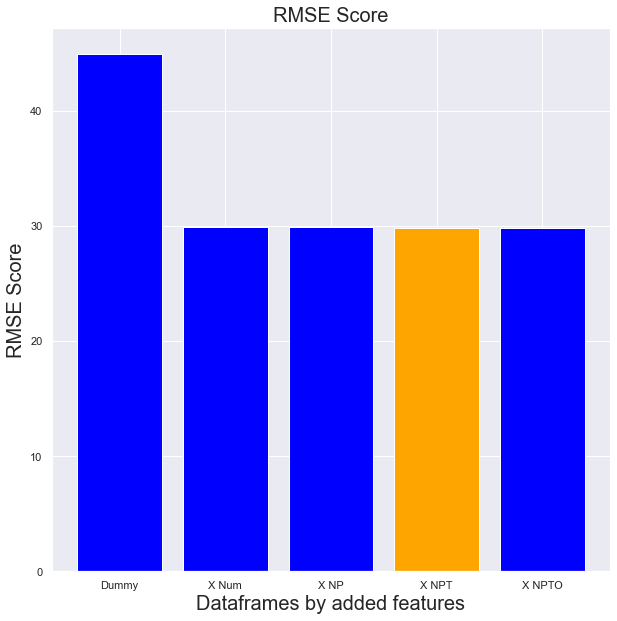

In [311]:
fig, ax = plt.subplots(figsize=(10,10))
colors = ["blue" if i != "X NPT" else "orange" for i in X_train_names]
ax.bar(x = X_train_names, height = RMSE_scores, color=colors)

ax.set_title("RMSE Score", fontsize=20)
ax.set_xlabel("Dataframes by added features",fontsize=20)
ax.set_ylabel("RMSE Score",fontsize=20)
plt.savefig('RMSE_scores.png')
;

In [319]:
top5_coef_name = list(test_coef_df.sort_values(by=1,ascending=False)[0][0:5])
top5_coef_val = list(test_coef_df.sort_values(by=1,ascending=False)[1][0:5])

In [321]:
# Cleaning up the feature names, so they'll be clear on the bar graph
top5_coef_name[0] = 'Target'
top5_coef_name[1] = 'PHI'
top5_coef_name[2] = 'DAL'
top5_coef_name[3] = 'MIN'
top5_coef_name[4] = 'DET'

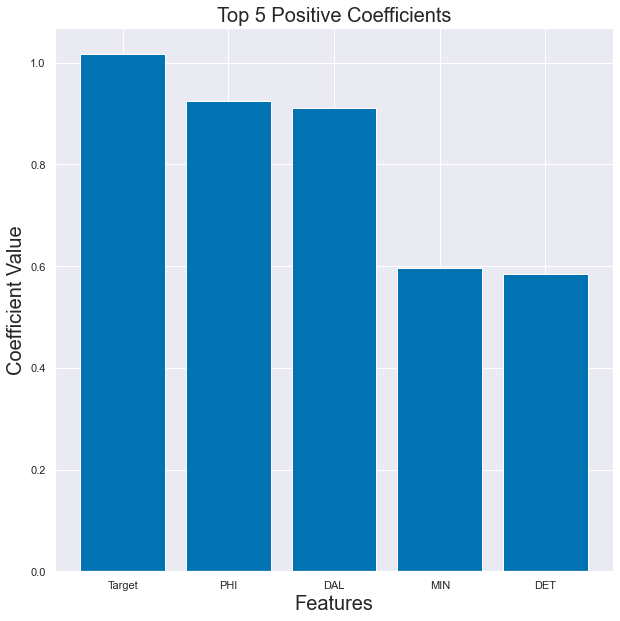

In [323]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x = top5_coef_name, height = top5_coef_val)

ax.set_title("Top 5 Positive Coefficients", fontsize=20)
ax.set_xlabel("Features",fontsize=20)
ax.set_ylabel("Coefficient Value",fontsize=20)
plt.savefig('Top5_Coeff.png');

### Creating a Dataframe of y_test predictions and y
- In order to compare and graph predictions vs actual more easily

In [285]:
error = pd.DataFrame(y_test_npt)

In [286]:
error['pred'] = y_test_pred

In [287]:
error['error'] = error['FP'] - error['pred']

In [288]:
error['%'] = error['error']/error['FP']

### Seeing Actual and Predicted on same graph, stacked on each other

''

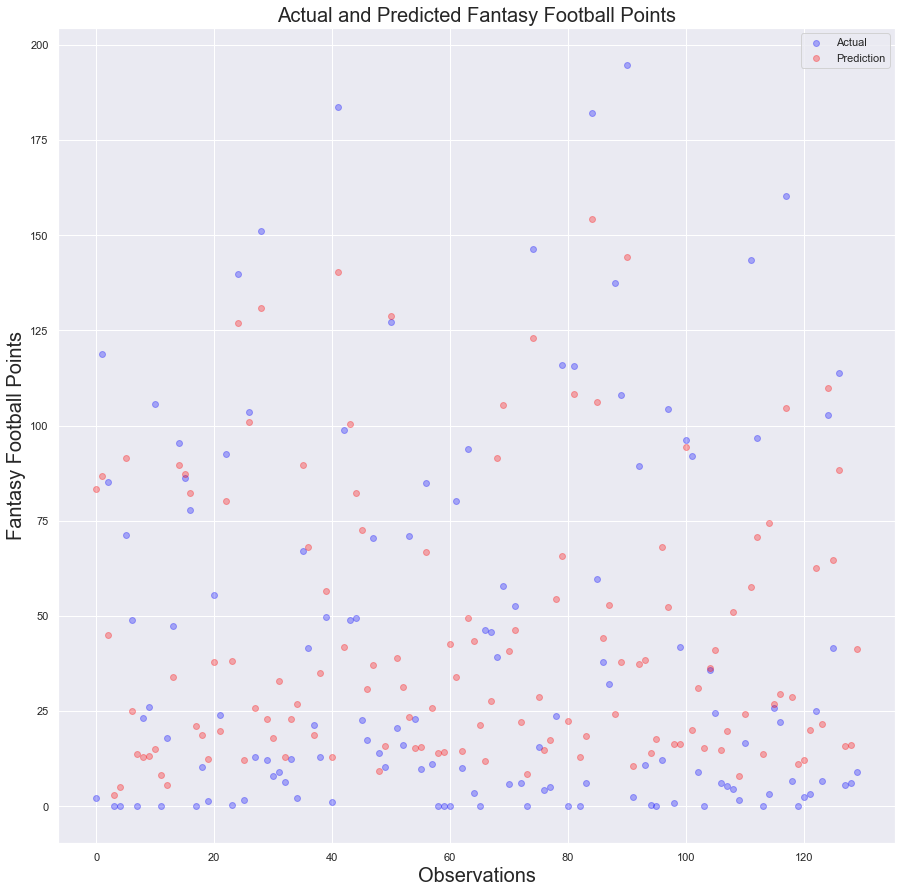

In [312]:
fig, ax = plt.subplots(figsize = (15,15))

ax.scatter(x = range(0, error['FP'].size), y = error['FP'],c='blue',label = 'Actual', alpha=0.3)
ax.scatter(x = range(0, error['pred'].size), y = error['pred'],c='red', label= 'Prediction', alpha=0.3)
plt.title('Actual and Predicted Fantasy Football Points', fontsize= 20)
plt.xlabel('Observations', fontsize= 20)
plt.ylabel('Fantasy Football Points', fontsize= 20)
plt.legend()
plt.savefig('actual_and_predicted.png')
;

### Seeing Actual vs Predicted Fantasy Points

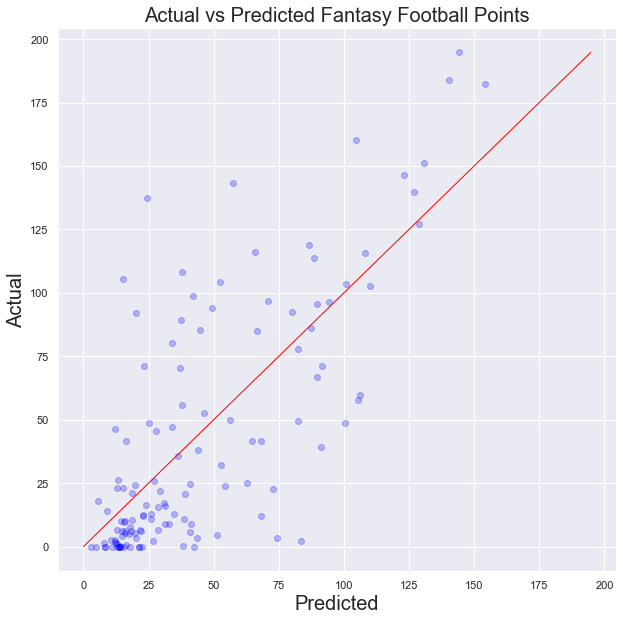

''

<Figure size 432x288 with 0 Axes>

In [313]:
fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(x=error['pred'], y = error['FP'],c='blue', alpha=0.25)
plt.title('Actual vs Predicted Fantasy Football Points', fontsize= 20)
plt.xlabel('Predicted', fontsize= 20)
plt.ylabel('Actual', fontsize= 20)

y_max = error['FP'].max()
y_min = error['FP'].min()
X_ref = Y_ref = np.linspace(y_min, y_max)

plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()
plt.savefig('actual_vs_pred.png')
;

### Seeing a histogram of prediction errors
- Want to see where the majority of errors lie, whether they tend to be small or large

''

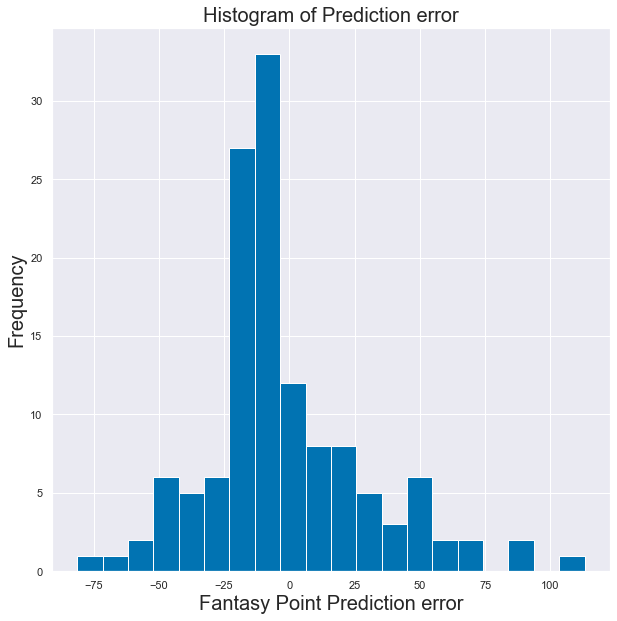

In [314]:
fig, ax = plt.subplots(figsize=(10,10))

ax.hist(error['error'],bins=20)
plt.title('Histogram of Prediction error', fontsize=20)
plt.xlabel('Fantasy Point Prediction error', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.savefig('hist_pred_err.png')
;

### Seeing the range in the test data

In [309]:
print(f"Max Points in Test Data: {error['FP'].max()}")
print(f"Min Points in Test Data: {error['FP'].min()}")

Max Points in Test Data: 194.74
Min Points in Test Data: 0.0


# Conclusion